In [ ]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader

In [ ]:
import pandas_datareader as pdr
import pandas as pd
key=""

import pandas_datareader.data as web
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
end = dt.datetime.today()
start = dt.datetime(2017, 1, 29)
df = web.DataReader('SPY', 'yahoo', start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-30,228.199997,226.410004,228.169998,227.550003,79737300.0,209.662949
2017-01-31,227.600006,226.320007,226.979996,227.529999,75880800.0,209.644501
2017-02-01,228.589996,226.940002,227.529999,227.619995,79117700.0,209.727463
2017-02-02,228.100006,226.820007,227.619995,227.770004,69657600.0,209.865646
2017-02-03,229.550003,228.460007,228.820007,229.339996,80563200.0,211.312241
...,...,...,...,...,...,...
2021-07-29,441.799988,439.809998,439.820007,440.649994,47435300.0,440.649994
2021-07-30,440.059998,437.769989,437.910004,438.510010,68890600.0,438.510010
2021-08-02,440.929993,437.209991,440.339996,437.589996,58783300.0,437.589996


In [ ]:
total_price = df['Close']
training_price = total_price[:int(total_price.shape[0]*0.9)]
test_price = total_price[int(total_price.shape[0]*0.9):]

print("Total prices shape " + str(total_price.shape[0]))
print("Train prices shape " + str(training_price.shape[0]))
print("Test prices shape " + str(test_price.shape[0]))

Total prices shape 1137
Train prices shape 1023
Test prices shape 114


# **(1) Traditional statistical time-series forecasting**

### **In the next segment we will use the traditional ARIMA model for the stock-price forecasting** 

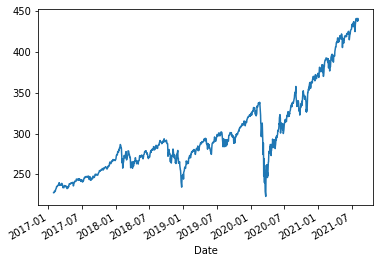

In [ ]:
#Checking the dataset plotting

import matplotlib.pyplot as plt

total_price.plot(kind='line')
plt.show()

In [ ]:
# using adfuller test for checking the null-hypothesis of non-stationarity
from statsmodels.tsa.stattools import adfuller

# The data is oviously not stationary, as the p-value is way higher then 0.05
result_non_stat = adfuller(total_price.dropna())
print('p-value: ' + str(result_non_stat[1]))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


p-value: 0.9609074830303236


In [ ]:
# First differencing the data to make it stationary 
diff = total_price.diff().dropna()

# The dataset is now stationary, as the p-value is less than 0.05
result_diff = adfuller(diff.dropna())
print('p-value: ' + str(result_diff[1]))

p-value: 1.9510919753021748e-17


## **Checking the ACF and PACF plots for order of lags**

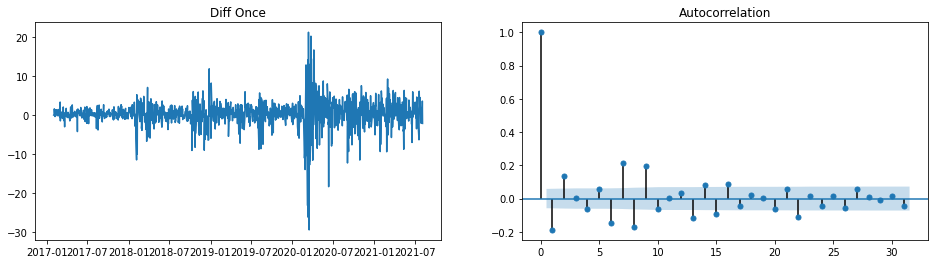

In [ ]:
""" (1) ACF plot """

from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].plot(diff)
axs[0].set_title('Diff Once')

plot_acf(diff, ax=axs[1]);

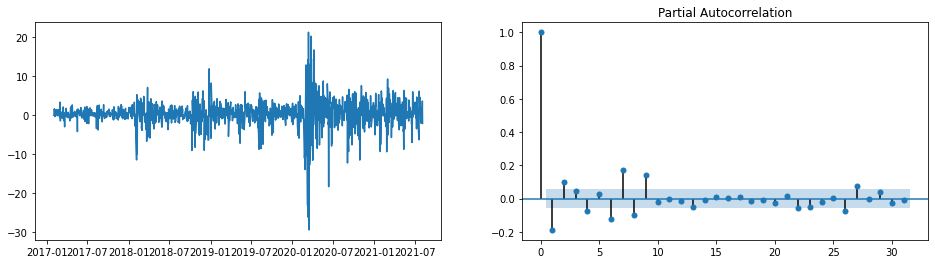

In [ ]:
""" (2) PACF plot """

from statsmodels.graphics.tsaplots import plot_pacf

fig, axs = plt.subplots(1, 2, figsize=(16,4))

axs[0].plot(diff)
plot_pacf(diff, ax=axs[1]);

### **From the above two plots, since both of the ACF and PACF plots are exponentially decaying, with a slight sinosidal shape; we can conclude that it is a combination of AR and MA models. To accurately check the lags for both of them applicable here, we can fit models of different lage to the dataset, and judge on the basis of of AIC scores**


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

best_aic = 10000000

# The model with the list AIC score is selected, with its respective parameters

for i in range(6):
  for j in range(6):
    model = ARIMA(training_price, order=(i, 1, j))
    result = model.fit(disp=0)

    if result.aic < best_aic:
      best_aic = result.aic
      best_ARIMA_param = (i, 1, j)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [ ]:
# Model training, and visualizing the results

best_arima = ARIMA(training_price, order=best_ARIMA_param)
result = best_arima.fit(disp=0)

result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 1022
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -2672.211
Method:                       css-mle   S.D. of innovations              3.305
Date:                Thu, 05 Aug 2021   AIC                           5364.422
Time:                        10:42:17   BIC                           5413.717
Sample:                             1   HQIC                          5383.138
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1557      0.112      1.390      0.165      -0.064       0.375
ar.L1.D.Close    -2.1992      0.117    -18.875      0.000      -2.428      -1.971
ar.L2.D.Close    -1.7987      0.197     -9.131      0.000      -2.185      -1.413
ar.L3.D.Close    -0.5113      0.103     -4.977      0.000      -0.713      -0.310
ma.L1.D.Close     2.1087      0.114     18.440      0.000       1.885       2.333
ma.L2.D.Close     1.7202      0.191      9.011      0.000       1.346       2.094
ma.L3.D.Close     0.6874      0.127      5.404      0.000       0.438       0.937
ma.L4.D.Close     0.2868      0.085      3.383      0.001       0.121       0.453
ma.L5.D.Close     0.1717      0.043      3.992      0.000       0.087       0.256
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9708           -0.5463j            1.1140           -0.4184
AR.2           -0.9708           +0.5463j            1.1140            0.4184
AR.3           -1.5759           -0.0000j            1.5759           -0.5000
MA.1           -1.0822           -0.0000j            1.0822           -0.5000
MA.2           -0.9067           -0.6440j            1.1121           -0.4017
MA.3           -0.9067           +0.6440j            1.1121            0.4017
MA.4            0.6125           -1.9941j            2.0861           -0.2026
MA.5            0.6125           +1.9941j            2.0861            0.2026
-----------------------------------------------------------------------------
"""

In [ ]:
# Future Price predictions

""" Here, we will take a walk-forward validation technique, as 
    in production level, we will need only a single time-stamp ahead for prediction """

step = 1

predictions_arima = []

for i in range(test_price.shape[0]):
  
  if i == 0:
    train_data = training_price
    
    best_arima = ARIMA(train_data, order=best_ARIMA_param)
    result = best_arima.fit(disp=0)
    
    fc, _ , _ = result.forecast(step)

    predictions_arima.append(fc)

  else:
    train_data = np.asarray(list(training_price[i:]) + list(test_price[:i]))

    best_arima = ARIMA(train_data, order=best_ARIMA_param)
    result = best_arima.fit(disp=0)
    
    fc, _ , _ = result.forecast(step)

    predictions_arima.append(fc)    

assert len(predictions_arima) == test_price.shape[0] # Sanity Check

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overf

114
114


## **Plotting the results**

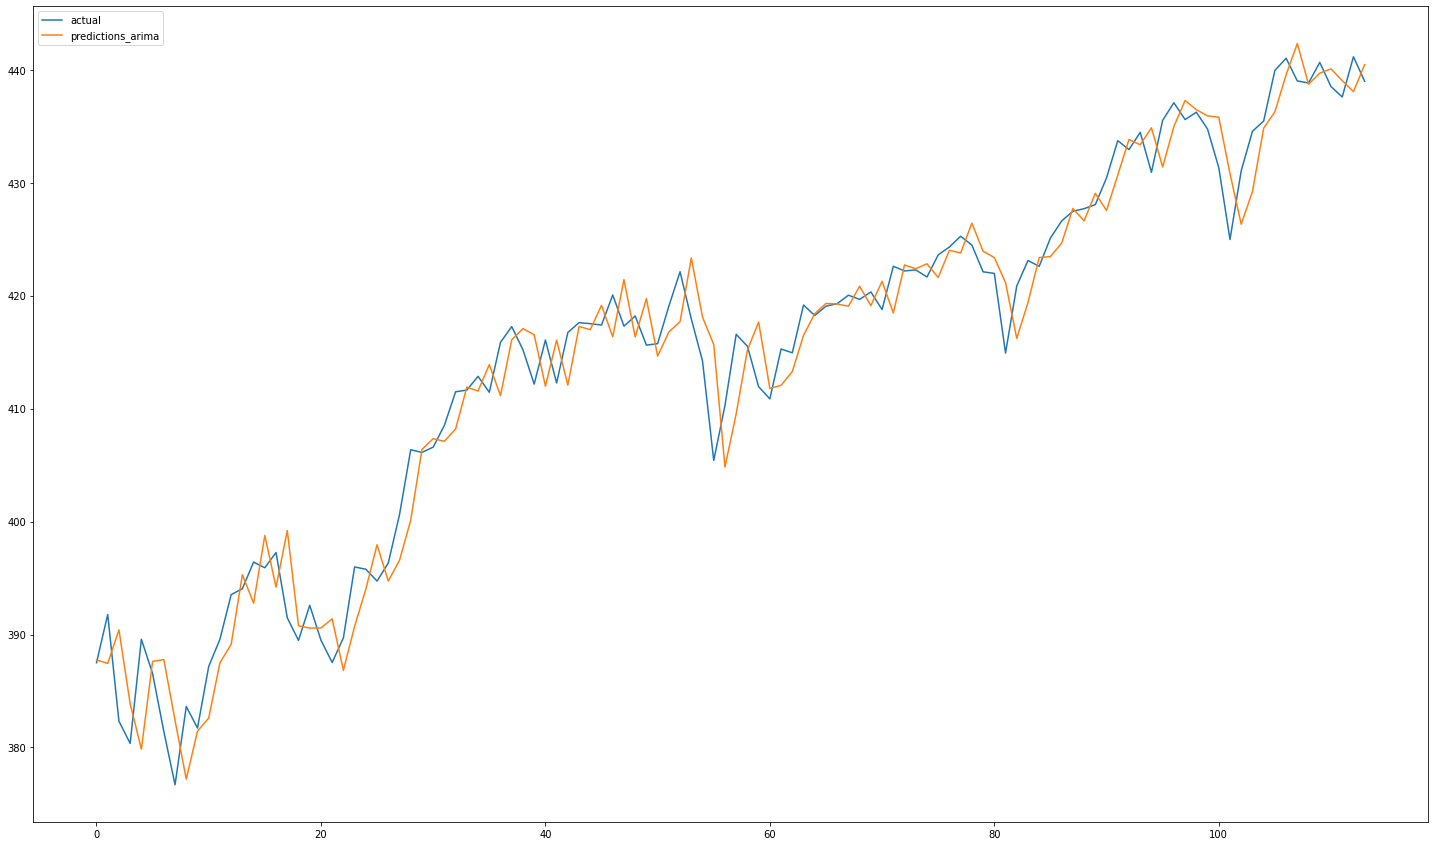

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(25,15))

axs.plot(list(test_price)[:len(predictions_arima)])
axs.plot(predictions_arima)
axs.legend(['actual', 'predictions_arima'])
plt.show()

# **(2) Using a traditional ML model**

In [65]:
""" Now, we will use XGBoost Regressor for time-series forecasting """

# We will use dataset of 3 columns, inform of 3 time-stamps behind; to train the model 
temp_1 = pd.DataFrame(total_price.shift(1))
temp_1.columns = ['t-1']
temp_2 = pd.DataFrame(total_price.shift(2))
temp_2.columns = ['t-2']
temp_3 = pd.DataFrame(total_price.shift(3))
temp_3.columns = ['t-3']

total_price_df = pd.DataFrame(total_price)
total_price_df.columns = ['close']

total_price_df = total_price_df.join([temp_1, temp_2, temp_3])
total_price_df.dropna(inplace=True)

In [66]:
# Creating the training and test set. We need to test the model on the same test dataset, to understand diff model performances

train_data_X = total_price_df.iloc[:-test_price.shape[0], 1:].values
train_data_Y = total_price_df.iloc[:-test_price.shape[0], 0].values

test_data_X = total_price_df.iloc[-test_price.shape[0]:, 1:].values
test_data_Y = total_price_df.iloc[-test_price.shape[0]:, 0].values

assert int(test_data_Y.shape[0]) == len(predictions_arima) # Sanity Check
assert test_data_Y[0] == test_price[0] # Sanity Check

In [67]:
# Checking the validity of the pipeline

from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', n_estimators = 1000)
model.fit(train_data_X, train_data_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
""" We will again use walk-forward validation technique to train and test the model simultaneoudly """

predictions_xgboost = []

for i in range(test_data_X.shape[0]):
  temp_X = np.reshape(test_data_X[i,:], (1, test_data_X[i,:].shape[0]))
  temp_Y = np.reshape(test_data_Y[i], (1,))
  
  x = model.predict(temp_X)    
  predictions_xgboost.append(x)
  
  # The sliding window method for updating training data
  train_data_X = np.vstack((train_data_X[1:,:], temp_X)) 
  train_data_Y = np.squeeze(np.vstack([np.expand_dims(train_data_Y[1:], axis=-1), np.expand_dims(temp_Y, axis=-1)]), axis=-1)

  model = XGBRegressor(objective='reg:squarederror', n_estimators = 1000)
  model.fit(train_data_X, train_data_Y)

assert len(predictions_xgboost) == len(predictions_arima) # Sanity Check

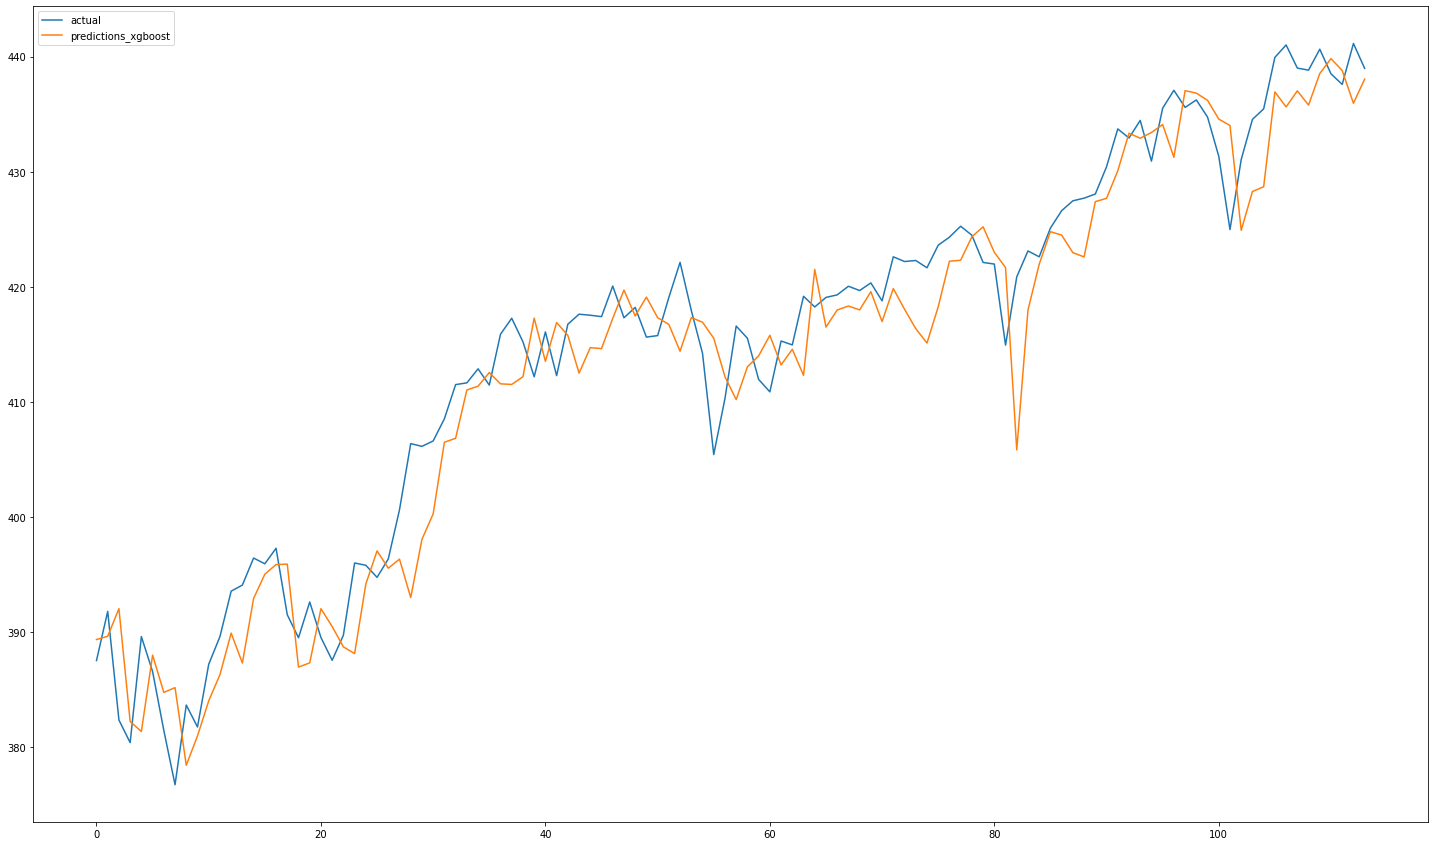

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(25,15))

axs.plot(test_data_Y) 
axs.plot(predictions_xgboost)
axs.legend(["actual", "predictions_xgboost"])
plt.show()

# **(3) Sequence Modelling for forecasting**

In [ ]:
price_array = np.array(training_price).reshape((len(training_price), 1))

# Scale data onto [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))

# Transform our data
spy_training_scaled = scaler.fit_transform(price_array)

# Build feauture and label sets using number of steps 20

features_set = []
labels = []
for i in range(20, len(training_price)):
    features_set.append(spy_training_scaled[i-20:i, 0])
    labels.append(spy_training_scaled[i, 0])
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
print(features_set.shape)
print(labels.shape)

(1003, 20, 1)
(1003,)


In [ ]:
# Import keras modules
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

# Build a Sequential keras model
model = Sequential()

# Add our first LSTM layer - 50 nodes
model.add(LSTM(units = 50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Add Dropout layer to avoid overfitting
model.add(Dropout(0.2))
# Add additional layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'acc'])

In [ ]:
# Fit the model to our data, running 100 training epochs
model.fit(features_set, labels, epochs = 50, batch_size = 32)

Epoch 1/50
32/32 [==============================] - 27s 42ms/step - loss: 0.0849 - mse: 0.0849 - acc: 2.9839e-04
Epoch 2/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0082 - mse: 0.0082 - acc: 0.0021
Epoch 3/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0070 - mse: 0.0070 - acc: 0.0022
Epoch 4/50
32/32 [==============================] - 1s 43ms/step - loss: 0.0062 - mse: 0.0062 - acc: 0.0014
Epoch 5/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0050 - mse: 0.0050 - acc: 0.0031
Epoch 6/50
32/32 [==============================] - 1s 44ms/step - loss: 0.0074 - mse: 0.0074 - acc: 0.0012
Epoch 7/50
32/32 [==============================] - 1s 46ms/step - loss: 0.0058 - mse: 0.0058 - acc: 0.0014
Epoch 8/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0060 - mse: 0.0060 - acc: 0.0068
Epoch 9/50
32/32 [==============================] - 1s 45ms/step - loss: 0.0050 - mse: 0.0050 - acc: 9.8399e-04
Epoch 10/50
32/32 [

In [ ]:
# Get and transform inputs for testing our predictions
test_inputs = total_price[-(20 + len(test_price)):].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

# Get test features
test_features = []
for i in range(20, (20 + len(test_price))):
    test_features.append(test_inputs[i-20:i, 0])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [ ]:
# Make predictions
predictions = model.predict(test_features)

# Transform predictions back to original data-scale
predictions_lstm = scaler.inverse_transform(predictions)

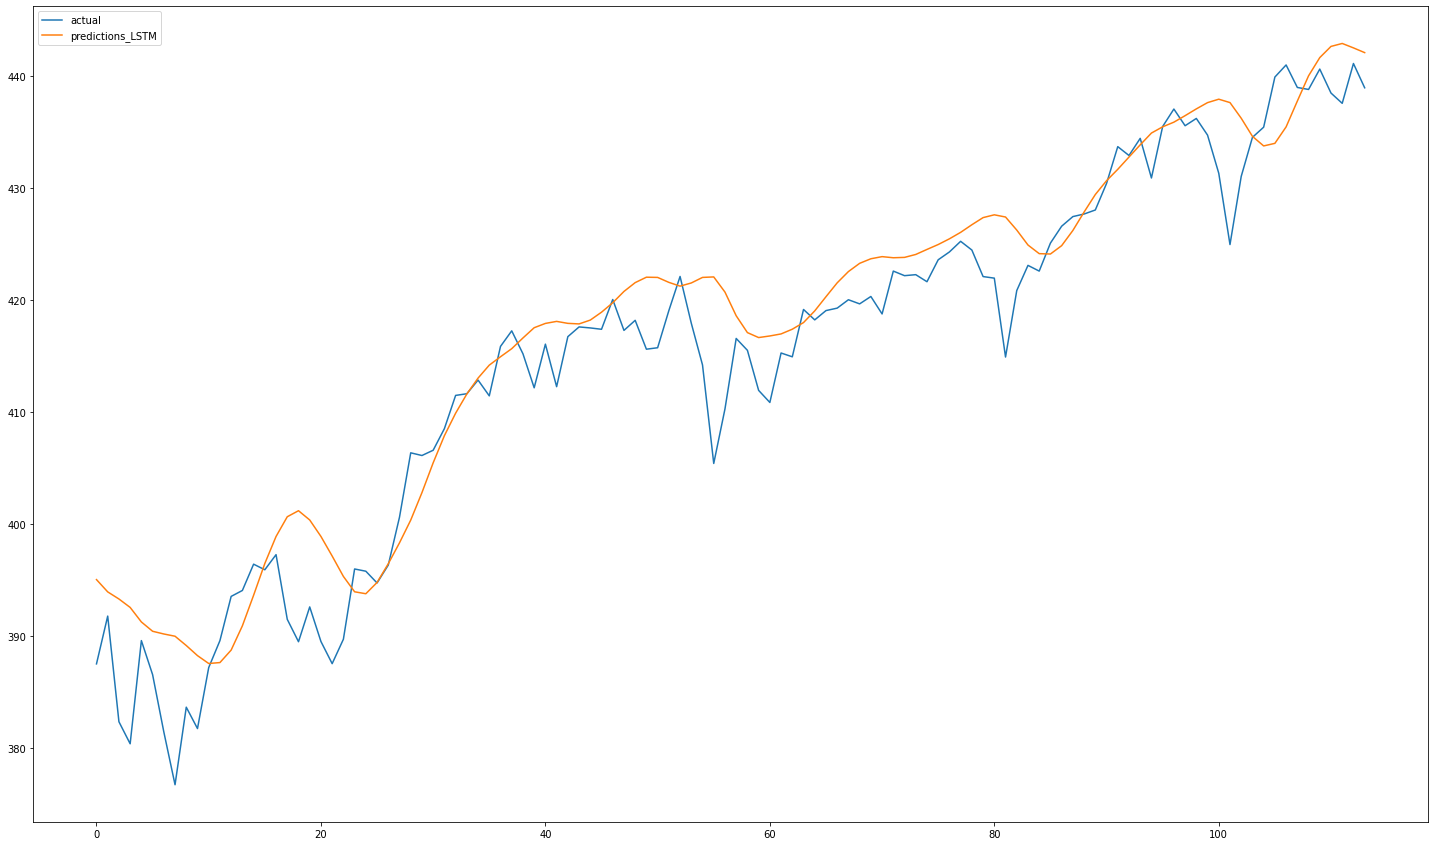

In [ ]:
# Plot our results!
plt.figure(figsize=(25,15))

plt.plot(list(test_price.values))
plt.plot(predictions_lstm)
plt.legend(['actual', 'predictions_LSTM'])
plt.show()

In [ ]:
# Sanity Check, before we choose the right weights
assert len(predictions_lstm) == len(predictions_arima) == len(predictions_xgboost)

## **Finding the right weights for ensemble of models**

In [71]:
""" Since each of the models can over or under-predict the market, we will find their individual weights from -1 to 1 each
    each with jump of 0.1. The best weights are used for ensembling the models in final prediction """

from sklearn.metrics import mean_squared_error

step_list = list(np.linspace(-1, 1, 21)) # All the possible weights for each model

least_error = 10000000

np_arima = np.asarray(predictions_arima)
np_xgboost = np.asarray(predictions_xgboost)
np_lstm = np.asarray(predictions_lstm)

for i in step_list:
  for j in step_list:
    for k in step_list:

      arr = i*np_arima + j*np_xgboost + k*np_lstm
      mse_error = mean_squared_error(test_price, arr)

      if mse_error < least_error:
        least_error = mse_error
        weights = np.asarray([i, j, k])

print("The least mse error is " + str(least_error))
print("Optimal Weights are " + str(weights))

The least mse error is 11.191848621196312
Optimal Weights are [0.7 0.1 0.2]


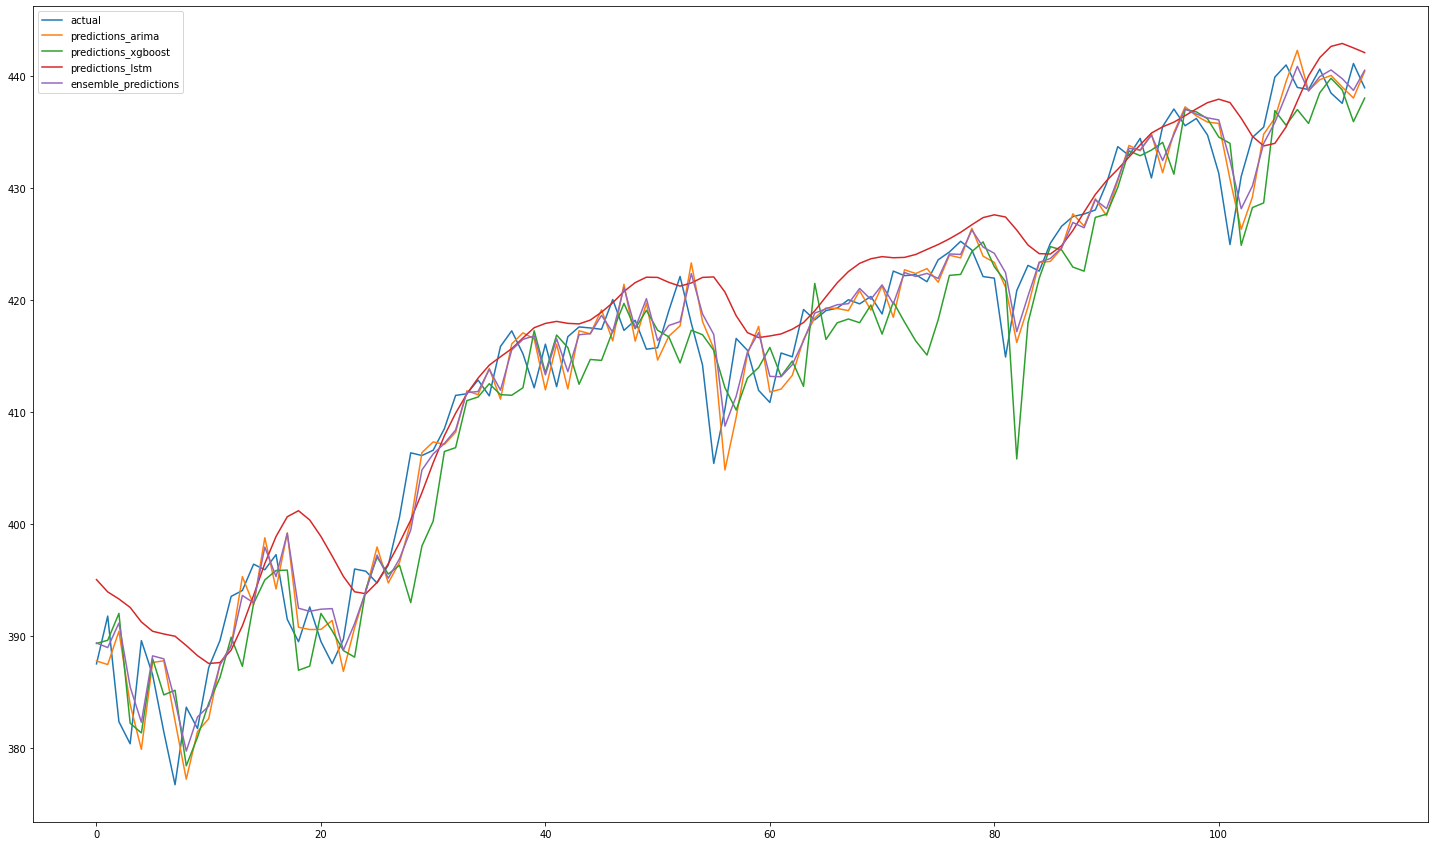

In [72]:
# Plot all of them together

plt.figure(figsize=(25,15))

plt.plot(list(test_price.values))
plt.plot(predictions_arima)
plt.plot(predictions_xgboost)
plt.plot(predictions_lstm)
plt.plot(list(weights[0]*np_arima + weights[1]*np_xgboost + weights[2]*np_lstm))

plt.legend(['actual', 'predictions_arima', 'predictions_xgboost', 'predictions_lstm', 'ensemble_predictions'])
plt.show()

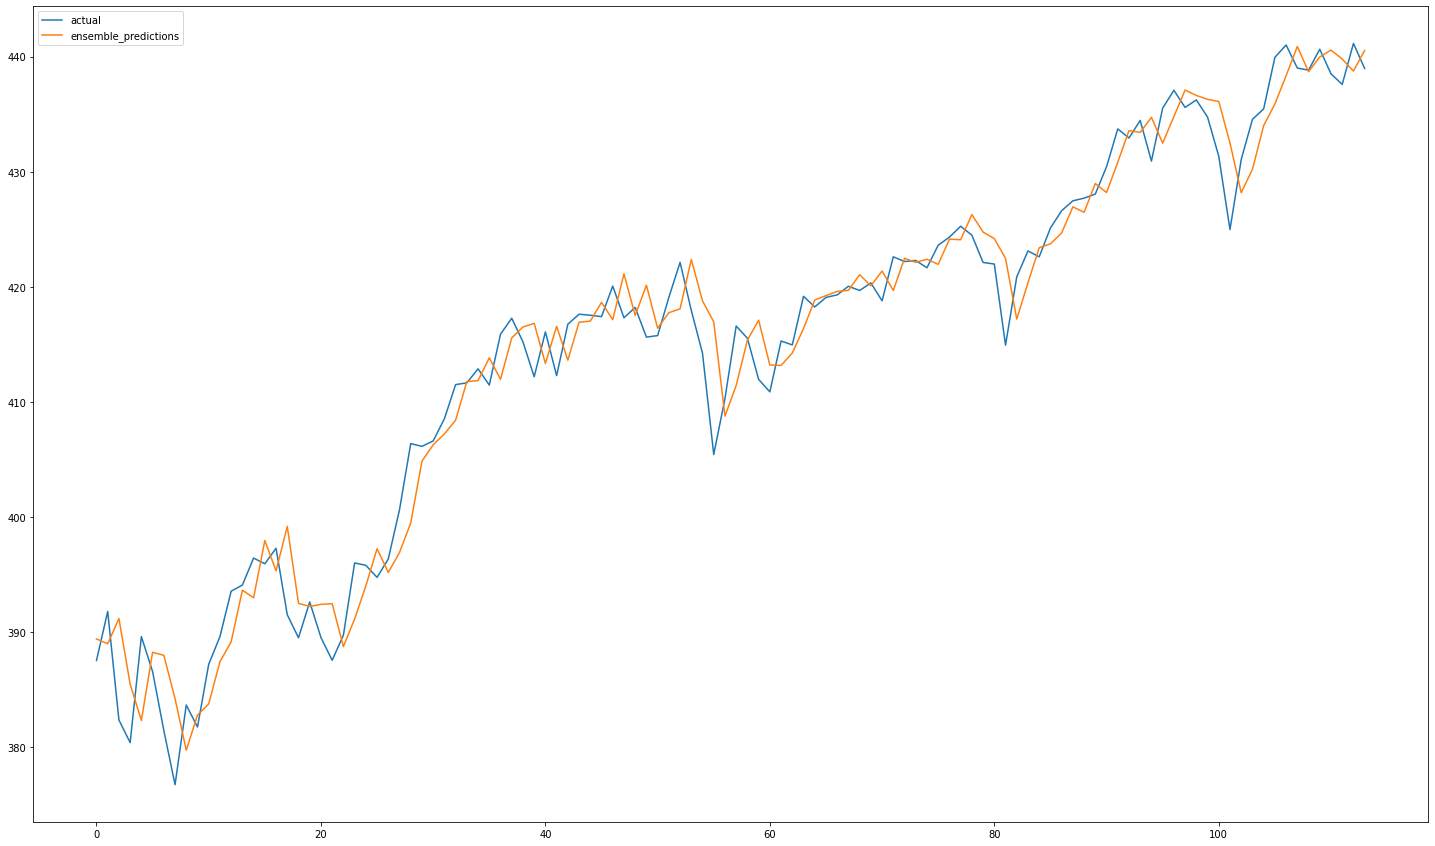

In [73]:
# Plotting just the ensemble preditions and actual prices

plt.figure(figsize=(25,15))

plt.plot(list(test_price.values))
plt.plot(list(weights[0]*np_arima + weights[1]*np_xgboost + weights[2]*np_lstm))

plt.legend(['actual','ensemble_predictions'])
plt.show()